### **Contexte et Justification de l'Étude**

Dans un monde de plus en plus connecté, la qualité de la connexion internet est un facteur déterminant pour les activités numériques quotidiennes, qu'il s'agisse de navigation, de streaming, de travail collaboratif ou de transactions en ligne. Les serveurs DNS (Domain Name System) jouent un rôle central dans ce processus en traduisant les noms de domaine en adresses IP compréhensibles par les machines, facilitant ainsi l'accès aux ressources en ligne. Parmi les serveurs DNS les plus utilisés figure le serveur DNS public de Google (8.8.8.8), connu pour sa fiabilité et ses performances.
Dans le cadre de cette étude, des requêtes ICMP (Internet Control Message Protocol) ont été envoyées au serveur DNS de Google pour collecter des données de latence entre 9:23:12 et 7:40:13 du jour d'après en mois de janvier. Ces échanges permettent de mesurer des indicateurs clés tels que le temps de latence, la variabilité des temps de réponse, et le taux de perte de paquets. Ces variables sont essentielles pour évaluer la performance de la connexion internet publique, car elles reflètent directement la rapidité et la stabilité du réseau.


### **Problématique** 


Le serveur DNS public de Google, pivot dans la traduction des noms de domaine en adresses IP, joue un rôle critique dans l'expérience utilisateur. Cependant, des fluctuations de latence, des pertes de paquets ou des anomalies peuvent perturber cette fluidité. La problématique réside donc dans la capacité à diagnostiquer et analyser ces paramètres pour comprendre l’état réel de la connexion publique et identifier d’éventuels goulots d’étranglement. Cette analyse est cruciale pour améliorer les performances réseau, optimiser l’expérience utilisateur et anticiper les besoins d’infrastructure.

## Importation de la session spark

In [1]:
from pyspark.sql import SparkSession

# **I. Présentation des données**

## **I.1. Description des données collectées**




La collecte des données a été déclenché à 9h23min12s et a pris fin le lendemain à 07h40min13s. ​ **(il suffit de d'ajouter à l'heure de départ la durée d'exécution du code qui a valu 80221 secondes, voir la dernière valeur de la variable "icmp_seq")** , il s'agit des données obtenu par exécution du code ping 8.8.8.8, 
qui a fait usage de requêtes ICMP envoyées au serveur DNS public de Google (8.8.8.8). Les échos reply reçus en réponse aux requêtes request permettent d'analyser plusieurs variables enregistrées au cours de cette période, parmi lesquels on a : le temps de latence, la variabilité des temps de réponse, et le taux de perte de paquets.


In [4]:
# Créer une session Spark
spark = SparkSession.builder.appName("Logs").getOrCreate()
from pyspark.sql.functions import regexp_extract, col

# Chemin d'accès d'importation
path = "Dataset - Projet 3 copy.txt"
df = spark.read.text(path)

# Extraction des variables pertinentes
data = df.withColumn("bytes", regexp_extract(col("value"), r"(\d+) bytes", 1)) \
               .withColumn("icmp_seq", regexp_extract(col("value"), r"icmp_seq=(\d+)", 1)) \
               .withColumn("ttl", regexp_extract(col("value"), r"ttl=(\d+)", 1)) \
               .withColumn("time", regexp_extract(col("value"), r"time=(\d+\.?\d*)", 1).cast("float"))

# Affichage des données extraites
data.show(2)



+--------------------+-----+--------+---+----+
|               value|bytes|icmp_seq|ttl|time|
+--------------------+-----+--------+---+----+
|Last login: Fri J...|     |        |   |NULL|
|serge-nd@MacBook-...|     |        |   |NULL|
+--------------------+-----+--------+---+----+
only showing top 2 rows



## **I.2. Préparation des données**

Cette partie consiste au nettoyage des données, notamment la gestion des valeurs manquantes et la préparation de la base finale qui servira aux analyses nécessaires pour cette étude. on commence par compter le nombre de où time est sans réponse

In [13]:
# Décompte du nombre de lignes où "time" est null
vid1=data.filter(col("time").isNull()).count()
print(f"Nombre de lignes où 'time' est vide : {vid1}")
vid2=data.filter(col("time").isNotNull()).count()
print(f"Nombre de lignes où 'time' est non vide : {vid2}")
vid=vid1+vid2
print(vid)

Nombre de lignes où 'time' est vide : 14500
Nombre de lignes où 'time' est non vide : 65722
80222


Il y a au total 14500 ICMP qui n'ont pas de réponse, nous allons les dissocier de la base afin de effectuer nos analyses

In [15]:
# Filtrer les lignes valides (où "time" n'est pas null)
non_vide = data.filter(col("time").isNotNull())

# résumé statistique des données nettoyées
non_vide.describe(["time", "ttl", "icmp_seq"]).show()

+-------+------------------+------------------+------------------+
|summary|              time|               ttl|          icmp_seq|
+-------+------------------+------------------+------------------+
|  count|             65722|             65722|             65722|
|   mean| 634.9307137911842|112.53330695961779| 17443.58853960622|
| stddev|15968.919069160678| 3.118295284174786|14289.437765940938|
|    min|            35.597|               100|                 0|
|    max|          927118.7|               114|              9999|
+-------+------------------+------------------+------------------+



# **II. Analyse Descriptive des Performances**

## **II.1. Statistiques globales**

In [18]:
from pyspark.sql.functions import avg, min, max, stddev

# Calcul des statistiques descriptives de la variable "time"
desc1 = non_vide.select(
    avg("time").alias("latence_moy"),
    min("time").alias("latence_min"),
    max("time").alias("latence_max"),
    stddev("time").alias("ecart_type_latence")
)

desc1.show()


+-----------------+-----------+-----------+------------------+
|      latence_moy|latence_min|latence_max|ecart_type_latence|
+-----------------+-----------+-----------+------------------+
|634.9307137911842|     35.597|   927118.7|15968.919069160678|
+-----------------+-----------+-----------+------------------+



**Ce tableau montre qu'en ce vendredi janvier 2025, dans la tranche de 9h à 15h au lendemain à 07h40min13s​, il fallait en moyenne attendre 634.93 ms  pour obtenir une reponse afin d'accéder à un site internet, la valeur très grande de l'étendue (max-min) suggère une connexion internet très instable au cours de cette période. Cette instabilité semble se confirmer par un écart-type de 15968.92 ms.**


In [20]:
# Calcul des statistiques descriptives de la variable "ttl"
desc2 = non_vide.select(
    avg("ttl").alias("Sauts_moy"),
    min("ttl").alias("Sauts_min"),
    max("ttl").alias("Sauts_max"),
    stddev("ttl").alias("ecart_type_Sauts")
)

desc2.show()


+------------------+---------+---------+-----------------+
|         Sauts_moy|Sauts_min|Sauts_max| ecart_type_Sauts|
+------------------+---------+---------+-----------------+
|112.53330695961779|      100|      114|3.118295284174786|
+------------------+---------+---------+-----------------+



**Se situant toujours dans cette période, Il fallait en moyenne 112,53 sauts (routeurs)  pour que la requête atteigne Google DSN (avant d'être rejeté), ces sauts varient entre 100 et 114, en associant cette information à un écart-type de 3.11, il a lieu de penser que le nombre de routeurs qui a chaque fois été nécéssaire pour atteindre Google DSN est quasiment resté le même.**

**On peut tout aussi bien dire qu'aucune cible n'a été atteinte avec moins de 100 sauts.**

## **II.2. Indicateurs de performance réseau**

Pour calculer le taux de perte de paquets, on compte le nombre total de requêtes envoyées et reçues, puis on fais le rapport

In [24]:
# Le nombre total de requêtes envoyées est donné par la variable vid1+vid2 (qui represente toute la base de données)

# Le nombre total de réponses reçues est donné par la variable vid2 (qui represente le nombre de réponses reçues) 

# Calcul du taux de perte de paquets
taux_1 = (vid1/(vid1+vid2)) * 100
print(f"Taux de perte de paquets : {taux_1:.3f}%")


Taux de perte de paquets : 18.075%


On peut remarquer que 18.075% de paquets ont été perdu, en d'autres termes des ICMP qui n'ont pas ontenu de réponse, ce qui est énorme et révélatrice d'un véritable problème de connexion.

## **II.3. Visualisation initiale**

On transformr d'abord data en dataFrame avant de l'afficher

In [28]:
# Import nécessaire
import pandas as pd
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

# Filtrer les données pour que "time" ne soit pas vide et convertir en DataFrame Pandas
data_filtre = data.filter(col("time").isNotNull()).select("icmp_seq", "time").toPandas()

# Afficher les premières lignes pour inspection
print(data_filtre.head())


  icmp_seq        time
0        0  548.916992
1        1  350.260010
2        2  530.039978
3        3  370.253998
4        4  424.649994


In [29]:
# S'assurer que les colonnes sont du bon type
data_filtre["icmp_seq"] = data_filtre["icmp_seq"].astype(int)
data_filtre["time"] = data_filtre["time"].astype(float)

# Création du graphique avec ggplot
plot = (
    ggplot(data_filtre, aes(x="icmp_seq", y="time")) +
    geom_line(color="blue", size=1) +  # Tracé de la ligne
    labs(
        title="Courbe des temps de latence par séquence ICMP",
        x="Numéro de séquence ICMP",
        y="Temps de latence (ms)"
    ) +
    theme_minimal()  # Style minimaliste
)
# Sauvegarde du graphique dans un fichier
plot.save("latence_par_icmp_seq.png", dpi=300)

# Afficher une confirmation
print("Le graphique a été enregistré sous le nom 'latence_par_icmp_seq.png'.")

# Afficher le graphique
print(plot)


C:\Users\LENOVO\anaconda3\Lib\site-packages\plotnine\ggplot.py:610: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\LENOVO\anaconda3\Lib\site-packages\plotnine\ggplot.py:611: PlotnineWarning: Filename: latence_par_icmp_seq.png


Le graphique a été enregistré sous le nom 'latence_par_icmp_seq.png'.
<ggplot: (640 x 480)>


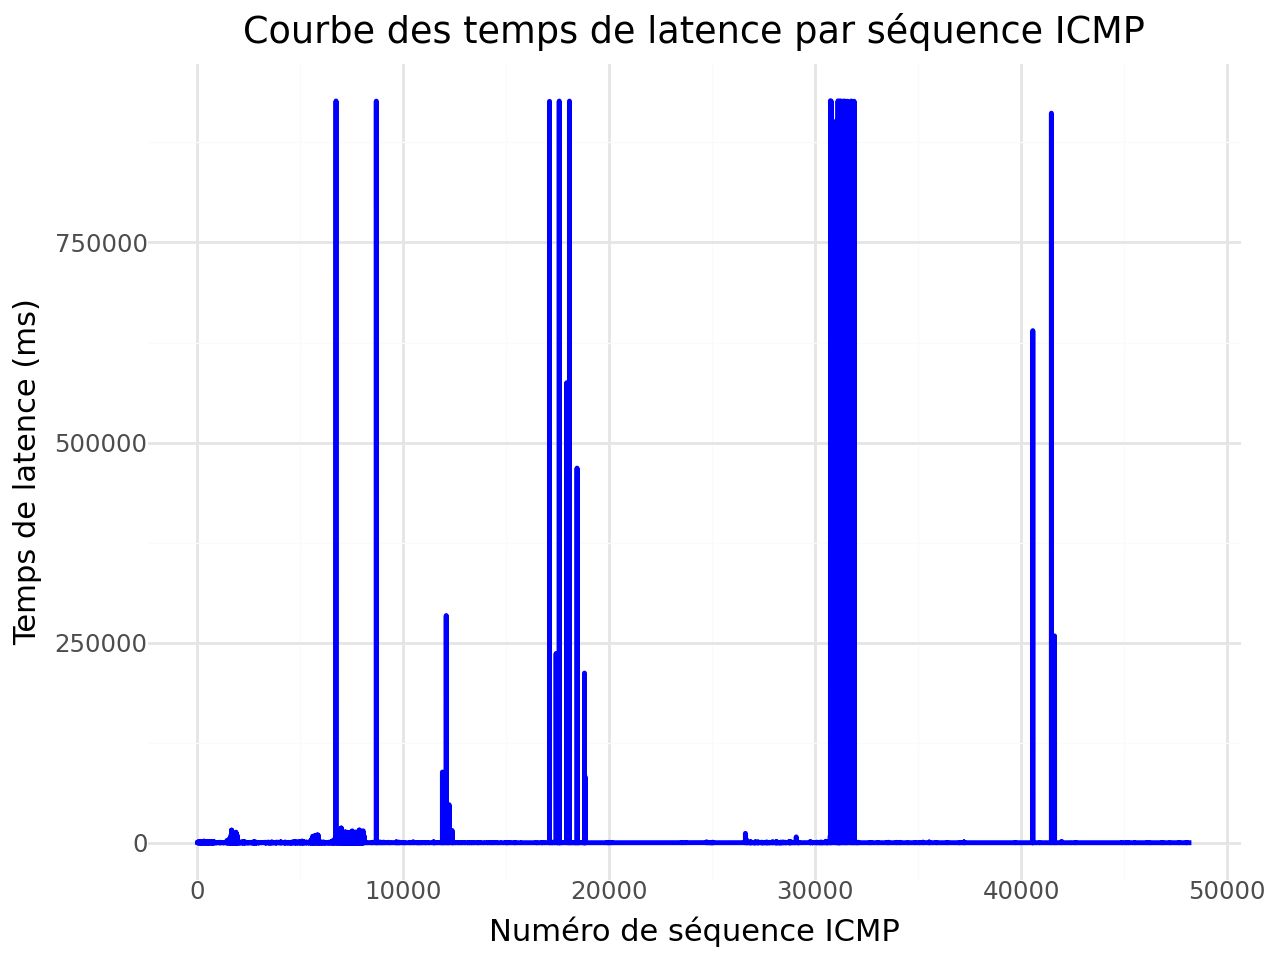

In [30]:
from plotnine.ggplot import ggplot

# Afficher directement dans un notebook Jupyter
from IPython.display import display

# Réafficher le graphique
display(plot)


Le graphique ci-dessus présente bien la distribution des 65722 réponses obtenues après lancement de 80221 requêtes, on peut soupçonner à quel point l'instabilité du réseau internet est remarquable 

Entre temps, lorsque les données sont collectées à une fréquence élevée (par exemple, chaque seconde), elles peuvent contenir des fluctuations mineures ou aléatoires qui n'ont pas de signification réelle. En regroupant par 10 secondes, on agrège les mesures, ce qui permet de mieux identifier des tendances globales et de réduire l'impact des variations ponctuelles.

In [33]:
from pyspark.sql.functions import floor

# Ajouter une colonne pour grouper les données par intervalles de 10 secondes
data_grouped = data.withColumn("time_group", (col("icmp_seq") / 10).cast("int"))

# Calculer la latence moyenne pour chaque groupe de 10 secondes
grouped_latency = data_grouped.groupBy("time_group").agg({"time": "avg"}).withColumnRenamed("avg(time)", "latence_moyenne")

# Trier les groupes pour afficher correctement les résultats
grouped_latency = grouped_latency.orderBy("time_group")

# Convertir en Pandas DataFrame pour la visualisation
grouped_latency_df = grouped_latency.toPandas()

# Afficher les premières lignes des données regroupées
print(grouped_latency_df.head())


   time_group  latence_moyenne
0         NaN              NaN
1         0.0       208.757199
2         1.0       260.506321
3         2.0       276.247232
4         3.0       302.182616


In [34]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

# Création du graphique avec ggplot
plot_grouped = (
    ggplot(grouped_latency_df, aes(x="time_group", y="latence_moyenne")) +
    geom_line(color="blue", size=1) +  # Tracé de la ligne
    labs(
        title="Courbe des latences moyennes par groupe de 10 secondes",
        x="Groupe de 10 secondes",
        y="Latence moyenne (ms)"
    ) +
    theme_minimal()  # Style minimaliste
)

# Afficher le graphique
print(plot_grouped)
plot_grouped.save("latence_moyenne_par_10_secondes.png", dpi=300)


<ggplot: (640 x 480)>


C:\Users\LENOVO\anaconda3\Lib\site-packages\plotnine\ggplot.py:610: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\LENOVO\anaconda3\Lib\site-packages\plotnine\ggplot.py:611: PlotnineWarning: Filename: latence_moyenne_par_10_secondes.png
C:\Users\LENOVO\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:99: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


C:\Users\LENOVO\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:99: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


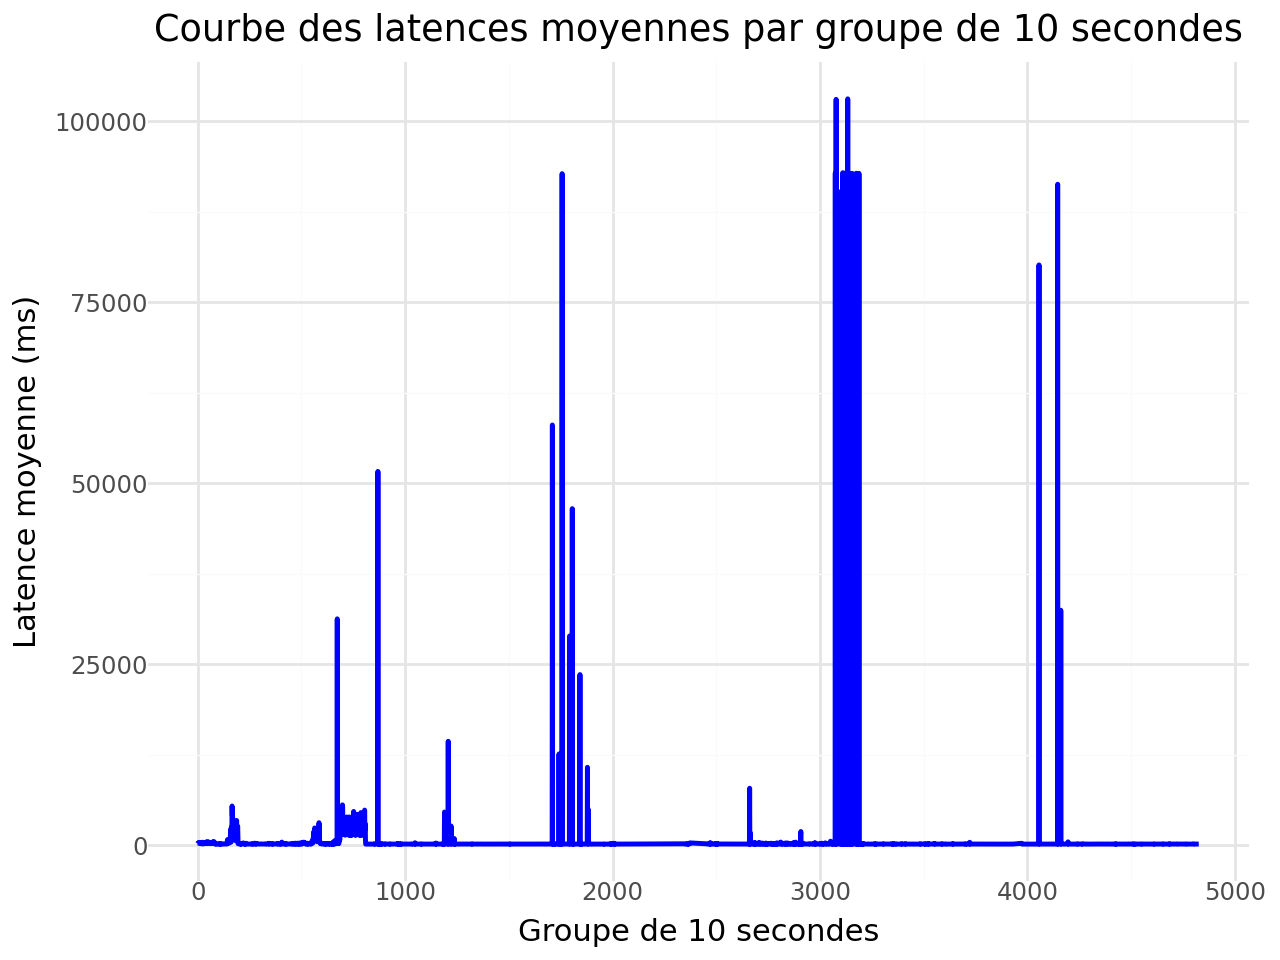

In [35]:
from plotnine.ggplot import ggplot

# Afficher directement dans un notebook Jupyter
from IPython.display import display

# Réafficher le graphique
display(plot_grouped)

La conclusion est la même, instabilité élevée

# **C'est ici que commence le calcul d'indicateurs supplémentaire :**

# Calcul de la gigue

Nous avons penser à mettre en place deux bases de données .text à partir de la base source, la base "ligne i.text" et la base "ligne i-1.text", l'objectif est d'avoir deux colonne, l'une prendra la ligne i et l'autre la ligne i-1, ceci afin de faire la différence en parallèle entre la ligne i et la ligne i-1. Au lieu de faire ce travail sur une seule colonne, ce qui risquerait de faire échouer les calculs. pour cela, nous avons supprimé la première ligne dans la base "ligne i" et nous avons supprimé la dernière ligne dans la base "ligne i-1"

## - Importation des deux bases ligne i et ligne i-1

In [5]:
path_i = "Data.txt"
df_i = spark.read.text(path_i)
# Extraction des variables pertinentes
df_i = df_i.withColumn("bytes", regexp_extract(col("value"), r"(\d+) bytes", 1)) \
               .withColumn("icmp_seq", regexp_extract(col("value"), r"icmp_seq=(\d+)", 1)) \
               .withColumn("ttl", regexp_extract(col("value"), r"ttl=(\d+)", 1)) \
               .withColumn("time_i", regexp_extract(col("value"), r"time=(\d+\.?\d*)", 1).cast("float"))

# Affichage des données extraites
df_i.show(2)


+--------------------+-----+--------+---+------+
|               value|bytes|icmp_seq|ttl|time_i|
+--------------------+-----+--------+---+------+
|64 bytes from 8.8...|   64|       1|105|350.26|
|64 bytes from 8.8...|   64|       2|105|530.04|
+--------------------+-----+--------+---+------+
only showing top 2 rows



In [6]:
path_i_1 = "Dataset.txt"
df_i_1 = spark.read.text(path_i_1)
# Extraction des variables pertinentes
df_i_1 = df_i_1.withColumn("bytes", regexp_extract(col("value"), r"(\d+) bytes", 1)) \
               .withColumn("icmp_seq", regexp_extract(col("value"), r"icmp_seq=(\d+)", 1)) \
               .withColumn("ttl", regexp_extract(col("value"), r"ttl=(\d+)", 1)) \
               .withColumn("time_i_1", regexp_extract(col("value"), r"time=(\d+\.?\d*)", 1).cast("float"))

# Affichage des données extraites
df_i_1.show(2)

+--------------------+-----+--------+---+--------+
|               value|bytes|icmp_seq|ttl|time_i_1|
+--------------------+-----+--------+---+--------+
|64 bytes from 8.8...|   64|       0|105| 548.917|
|64 bytes from 8.8...|   64|       1|105|  350.26|
+--------------------+-----+--------+---+--------+
only showing top 2 rows



## On va indexer les deux base pour faire la jointure, ceci afin de mettre les deux variables time_i et time_i_1 ensemble

In [8]:
from pyspark.sql.functions import monotonically_increasing_id

# Ajouter une colonne 'index' unique à df_i_1
df_i_1_ = df_i_1.withColumn("index", monotonically_increasing_id())
df_i_ = df_i.withColumn("index", monotonically_increasing_id())
df_i_.show(5)
df_i_1.show(5)

+--------------------+-----+--------+---+-------+-----+
|               value|bytes|icmp_seq|ttl| time_i|index|
+--------------------+-----+--------+---+-------+-----+
|64 bytes from 8.8...|   64|       1|105| 350.26|    0|
|64 bytes from 8.8...|   64|       2|105| 530.04|    1|
|64 bytes from 8.8...|   64|       3|105|370.254|    2|
|64 bytes from 8.8...|   64|       4|105| 424.65|    3|
|64 bytes from 8.8...|   64|       5|105|142.222|    4|
+--------------------+-----+--------+---+-------+-----+
only showing top 5 rows

+--------------------+-----+--------+---+--------+
|               value|bytes|icmp_seq|ttl|time_i_1|
+--------------------+-----+--------+---+--------+
|64 bytes from 8.8...|   64|       0|105| 548.917|
|64 bytes from 8.8...|   64|       1|105|  350.26|
|64 bytes from 8.8...|   64|       2|105|  530.04|
|64 bytes from 8.8...|   64|       3|105| 370.254|
|64 bytes from 8.8...|   64|       4|105|  424.65|
+--------------------+-----+--------+---+--------+
only showing

# Jointure sur l'index

In [9]:
# Effectuer la jointure sur la colonne 'product_id'
df_ajout = df_i_1_.join(df_i_, on="index", how="left")
df_ajout=df_ajout.orderBy(col("index"))

# Afficher le résultat
df_ajout.show(5)

+-----+--------------------+-----+--------+---+--------+--------------------+-----+--------+---+-------+
|index|               value|bytes|icmp_seq|ttl|time_i_1|               value|bytes|icmp_seq|ttl| time_i|
+-----+--------------------+-----+--------+---+--------+--------------------+-----+--------+---+-------+
|    0|64 bytes from 8.8...|   64|       0|105| 548.917|64 bytes from 8.8...|   64|       1|105| 350.26|
|    1|64 bytes from 8.8...|   64|       1|105|  350.26|64 bytes from 8.8...|   64|       2|105| 530.04|
|    2|64 bytes from 8.8...|   64|       2|105|  530.04|64 bytes from 8.8...|   64|       3|105|370.254|
|    3|64 bytes from 8.8...|   64|       3|105| 370.254|64 bytes from 8.8...|   64|       4|105| 424.65|
|    4|64 bytes from 8.8...|   64|       4|105|  424.65|64 bytes from 8.8...|   64|       5|105|142.222|
+-----+--------------------+-----+--------+---+--------+--------------------+-----+--------+---+-------+
only showing top 5 rows



## Variation du délai moyen (MPPDV : Mean Packet to Packet Delay Variation ) : en RFC 4689 (Poretsky et al., 2006), IETF présente la gigue comme la moyenne de la valeur absolue de la mesure IPDV. 

In [10]:
from pyspark.sql.functions import abs, col

# Ajouter une nouvelle colonne 'time_diff' pour la différence absolue entre 'time_i' et 'time_i_1'
df_ajout = df_ajout.withColumn("time_diff", abs(col("time_i") - col("time_i_1")))
# Afficher le résultat
df_ajout.show(5)


+-----+--------------------+-----+--------+---+--------+--------------------+-----+--------+---+-------+---------+
|index|               value|bytes|icmp_seq|ttl|time_i_1|               value|bytes|icmp_seq|ttl| time_i|time_diff|
+-----+--------------------+-----+--------+---+--------+--------------------+-----+--------+---+-------+---------+
|    0|64 bytes from 8.8...|   64|       0|105| 548.917|64 bytes from 8.8...|   64|       1|105| 350.26|198.65698|
|    1|64 bytes from 8.8...|   64|       1|105|  350.26|64 bytes from 8.8...|   64|       2|105| 530.04|179.77997|
|    2|64 bytes from 8.8...|   64|       2|105|  530.04|64 bytes from 8.8...|   64|       3|105|370.254|159.78598|
|    3|64 bytes from 8.8...|   64|       3|105| 370.254|64 bytes from 8.8...|   64|       4|105| 424.65|54.395996|
|    4|64 bytes from 8.8...|   64|       4|105|  424.65|64 bytes from 8.8...|   64|       5|105|142.222|282.42798|
+-----+--------------------+-----+--------+---+--------+--------------------+---

Calcul de la gigue qui est la moyenne de la valeur absolue des différences

In [11]:
from pyspark.sql.functions import avg
# Supprimer les lignes où la colonne 'time' est NULL
data_filtre = df_ajout.filter(df_ajout["time_diff"].isNotNull())
# Calculer la moyenne de la colonne 'time_diff'
moyenne_time_diff = data_filtre.agg(avg("time_diff")).collect()[0][0]

# Afficher la moyenne
print(f"La moyenne de 'time_diff' est : {moyenne_time_diff}")

La moyenne de 'time_diff' est : 500.1217974368544


D'après https://www.iptis.fr/blog/comprendre-la-qualite-de-sa-connexion-internet, une bonne gigue est d'une valeur inférieur à 20ms, ici la gigne est de 500.122, ce qui est largement supérieur à 20ms, on peut donc dire que le délai entre les paquets de données varie de manière significative, une gigue de 500.122 ms pourrait entraîner des délais importants avant de recevoir une réponse. Cela montre que la navigation sur internet peut devenir très lente, ceci à cause d'une grande fluctuation dans le temps que met chaque paquet pour parcourir le réseau, avec des variations allant de 0 à 500 ms

# Méthode de calcul manuel de la moyenne

In [53]:
from pyspark.sql.functions import col, sum, count

# Filtrer les valeurs non nulles
data_filtre = df_ajout.filter(col("time_diff").isNotNull())
# Calculer la somme des valeurs de 'time_diff'
somme_time_diff = data_filtre.agg(sum("time_diff")).collect()[0][0]

# Calculer le nombre de valeurs non nulles
nb_valeurs = data_filtre.agg(count("time_diff")).collect()[0][0]
# Calculer la moyenne manuellement
moyenne_time_diff = somme_time_diff / nb_valeurs

# Afficher la moyenne
print(f"La moyenne de 'time_diff' est : {moyenne_time_diff}")


La moyenne de 'time_diff' est : 500.1217974368544


# Calcul des fréquences d'apparition des ttl

In [55]:
# Supprimer les lignes où la colonne 'time' est NULL
data_filtre = data.filter(data["time"].isNotNull())

In [56]:
from pyspark.sql import functions as F

# Supprimer les lignes où 'ttl' est NULL
df_filtered = data_filtre.filter(data_filtre["ttl"].isNotNull())

# Compter les occurrences de 'ttl' après suppression des NULLs
df_count = df_filtered.groupBy("ttl").agg(F.count("ttl").alias("count"))

# Afficher le résultat
df_count.show()

+---+-----+
|ttl|count|
+---+-----+
|110|  730|
|100|   61|
|103|  190|
|114|52883|
|105| 7810|
|109| 4048|
+---+-----+



In [57]:
from pyspark.sql import functions as F

# Compter les occurrences de 'ttl'
df_count = data_filtre.groupBy("ttl").agg(F.count("ttl").alias("count"))

# Calculer la fréquence
total_count = data_filtre.count()  # Nombre total de lignes
df_count = df_count.withColumn("frequency", df_count["count"] *100/ total_count)

# Afficher le résultat
df_count.show()

+---+-----+-------------------+
|ttl|count|          frequency|
+---+-----+-------------------+
|110|  730| 1.1107391740969539|
|100|   61|0.09281519126015642|
|103|  190| 0.2890964973677003|
|114|52883|  80.46468458050576|
|105| 7810| 11.883387602324945|
|109| 4048|  6.159276954444478|
+---+-----+-------------------+



La majorité des paquets prennent un chemin impliquant 114 sauts. Cela suggère que le routage suit un chemin long et relativement constant pour la majorité des requêtes (80.46%). Le reste des paquets emprunte des chemins alternatifs avec moins de sauts.L'écart entre les TTL (de 100 à 114) peut dtraduire des variations fréquentes potentiellement causés par des problèmes de réseau ou une optimisation dynamique par les routeurs.